## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data",
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
train_data = prostate.drop("train", axis=1)[prostate["train"] == "T"]
test_data = prostate.drop("train", axis=1)[prostate["train"] == "F"]

scaler = StandardScaler()
scaler.fit(train_data)
train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.transform(test_data)
X_train = train_data_std[:, :-1]
y_train = train_data_std[:, -1]
X_test = test_data_std[:, :-1]
y_test = test_data_std[:, -1]

## 主成分回归

In [75]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [67]:
class PrincipalComponentsRegression(BaseEstimator, RegressorMixin):
    """
    主成分回归
    参数：
    -----
    n_components: 主成分的数量
    
    属性：
    -----
    weigths: 主成分的线性系数
    """
    
    def __init__(self, n_components=None):
        self.n_components = n_components
    
    def fit(self, X, y=None):
        n, p = X.shape
        if self.n_components == None:
            self.n_components = min(n, p)  
            
        if self.n_components < 1:
            raise ValueError("The number of principal components should be" +
                             "greater than or equal to 1!")
        U, s, vh = np.linalg.svd(X, full_matrices=False)
        self.weights = vh.T[:, :self.n_components] @ ((U[:, :self.n_components].T @ y) / s[:self.n_components])
        
        return self      
        
    def predict(self, X):
        y_pred = X @ self.weights
        return y_pred

In [68]:
pcr = PrincipalComponentsRegression(n_components=5) # 使用5个主成分
pcr.fit(X_train, y_train)

PrincipalComponentsRegression(n_components=5)

In [69]:
y_pred = pcr.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.388


In [70]:
y_pred = pcr.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.376


In [71]:
pcr.weights

array([ 0.26283461,  0.23920229, -0.04564946,  0.2237626 ,  0.21654314,
        0.2180089 , -0.00863872,  0.06737596])

### 寻找最优参数

In [47]:
from sklearn.model_selection import GridSearchCV

In [73]:
n_components_lst = np.arange(1, 9)
param_grid = {'n_components': n_components_lst}
pcr_cv = GridSearchCV(PrincipalComponentsRegression(), param_grid=param_grid, 
                        cv=10, 
                        scoring='neg_mean_squared_error',
                        return_train_score=True)
pcr_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=PrincipalComponentsRegression(),
             param_grid={'n_components': array([1, 2, 3, 4, 5, 6, 7, 8])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [78]:
best_param = pcr_cv.best_params_
print("最优主成分数量：{}".format(best_param['n_components']))

最优主成分数量：8


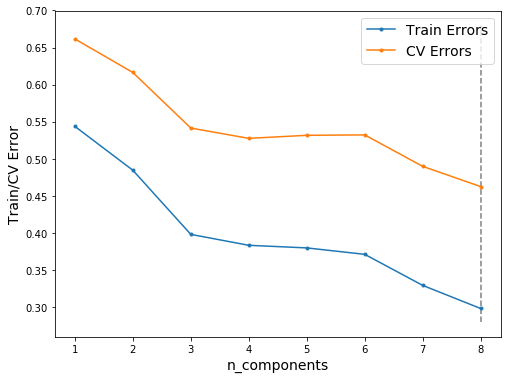

In [77]:
# 画出验证误差曲线
train_errs = -pcr_cv.cv_results_['mean_train_score']
cv_errs = -pcr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(n_components_lst, train_errs, ".-", label="Train Errors")
plt.plot(n_components_lst, cv_errs, ".-", label="CV Errors")
plt.vlines(pcr_cv.best_estimator_.n_components, 
           plt.ylim()[0], plt.ylim()[1],
           color="gray", linestyles="--")
plt.legend(fontsize=14)
plt.xlabel("n_components", fontsize=14)
plt.ylabel("Train/CV Error", fontsize=14)
plt.show()

### 使用最优参数模型

In [79]:
pcr_best = pcr_cv.best_estimator_

In [80]:
y_train_pred = pcr_best.predict(X_train)
train_err = mean_squared_error(y_train, y_train_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [81]:
y_test_pred = pcr_best.predict(X_test)
test_err = mean_squared_error(y_test, y_test_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.363


In [83]:
pd.options.display.float_format = '{:.3f}'.format
variables = ["Intercept"] + list(train_data.iloc[:, :-1].columns)
pd.DataFrame({"变量": variables, 
              "值": np.r_[train_data.iloc[:, -1].mean(), pcr_best.weights]})

,变量,值
0,Intercept,2.452
1,lcavol,0.593
2,lweight,0.242
3,age,-0.118
4,lbph,0.176
5,svi,0.256
6,lcp,-0.239
7,gleason,-0.017
8,pgg45,0.230
